In [5]:
import numpy as np

from pathlib import Path
import random

import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '/code/src')

from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import create_raster, create_psth, create_confusion_matrix
from classifier import get_classifier, run_classifier

In [7]:
example_sessions = [1139846596, 1152811536, 1069461581 ]
this_session = str(example_sessions[0])
this_filename = f'ecephys_session_{this_session}.nwb'
nwb_path = Path('visual-behavior-neuropixels', 'behavior_ecephys_sessions', this_session, this_filename)
session, _, stimuli, units_table = process_nwb_metadata(nwb_path)
unq_stim, stim_id = np.unique(stimuli.image_name, return_inverse = True)

In [12]:
# Choose a neuron to analyze
unit = 6
spike_times = units_table.spike_times.values[unit]
stim_times = stimuli.start_time.values

# Timing constants
pre_window = 0.2 
post_window = 0.75
bin_size = 0.01

# Create a raster
triggered_spike_times, triggered_stim_index = get_stim_window(spike_times, stim_times, pre_window=pre_window, post_window=post_window)

In [21]:
type(stimuli)

pandas.core.frame.DataFrame

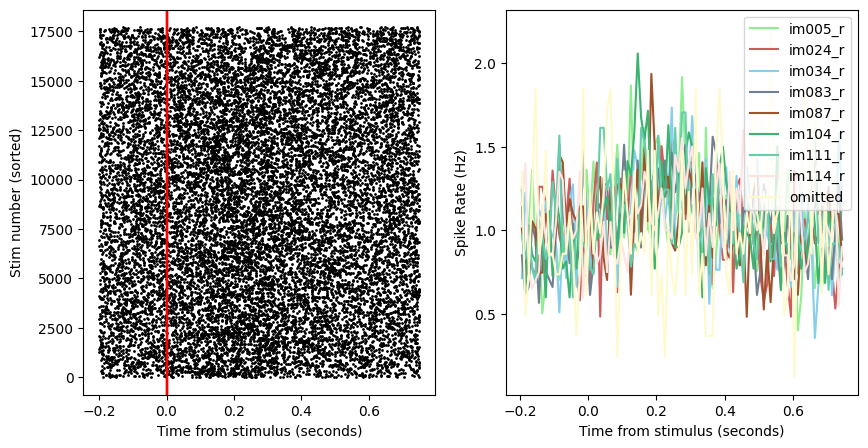

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

colors = list(mcolors.CSS4_COLORS)
random.shuffle(colors)

# A counter, useful for stacking plots
counter = 0

# Loop through trial types

for ii in range(len(unq_stim)):
    # Plot the raster just for this stimulus type

    # spike times for this trial type
    this_triggered_spike_times = triggered_spike_times[stim_id[triggered_stim_index.astype(int)]==ii]

    # trial index subselected by this trial type.
    this_trl_idx = np.arange(np.sum(stim_id[triggered_stim_index.astype(int)]==ii)) 

    # Plot
    create_raster(this_triggered_spike_times, this_trl_idx + counter, ax[0])
    
    # stack the plots
    counter += np.max(this_trl_idx)
    
    # Plot the raster just for this stimulus type
    color = colors[ii]
    create_psth(this_triggered_spike_times, this_trl_idx, ax[1], label=unq_stim[ii], color=color)
ax[1].legend() # Plot a legend using the established labels.

In [15]:
# Get the spike counts for all neurons
bins = np.arange(-pre_window, post_window, bin_size)
spike_count = get_spike_counts_all(units_table, stim_times, bins)

In [16]:
# Get the stimuli information
change_number = 0
stimulus_change_number = stimuli.flashes_since_change.values

inc_time_idx = np.where((bins>=0) & (bins<.3))[0] # select times to include
start_idx = np.min(inc_time_idx)
end_idx = np.max(inc_time_idx)

# Find the number of spikes in the selected window
X = np.sum(spike_count[:, stimulus_change_number==change_number, start_idx:end_idx], axis=2).T 

# And the trial identity for each of the selected stimuli
_, trial_id = np.unique(stimuli.image_name.values, return_inverse=True)
y = trial_id[stimulus_change_number==change_number]

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y)
svc = fit_classifier(x_train, y_train)
y_pred, score = run_classifier(svc, x_test, y_test)
print(f'Model score: {score}')

Model score: 1.0


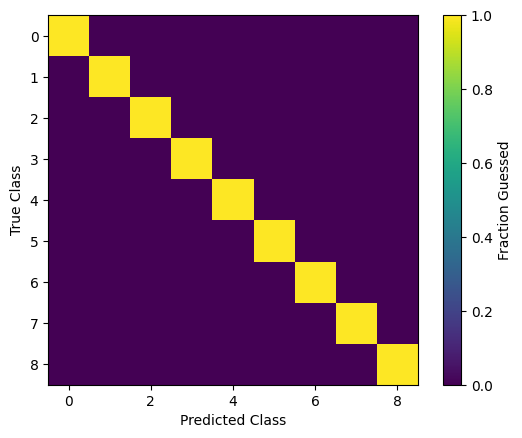

In [17]:
fig, ax = plt.subplots()
create_confusion_matrix(ax, y_pred, y_test)

In [18]:
scores_train = np.zeros(len(bins)-1)
scores_test = np.zeros(len(bins)-1) 

# Loop through and fit a model to each time bin.
for ii in range(len(bins)-1):
    X = spike_count[:,stimulus_change_number==change_number, ii].T
    y = trial_id[stimulus_change_number==change_number]
    x_train, x_test, y_train, y_test = train_test_split(X, y)

    svc = get_classifier(x_train, y_train)
    _, train_score = run_classifier(svc, x_train, y_train)
    _, test_score = run_classifier(svc, x_test, y_test)

    scores_train[ii] = train_score
    scores_test[ii] = test_score

In [19]:
chance_est = []
for ii in range(1000):
    shuffled_trial_id = trial_id[np.random.randint(len(trial_id))]
    chance_est.append(np.sum(trial_id==shuffled_trial_id)/len(trial_id))

chance = np.mean(chance_est)
print(f'Bootstrapped chance estimate: {chance}')

Bootstrapped chance estimate: 0.11682615032271498


Text(0, 0.5, 'Model Score')

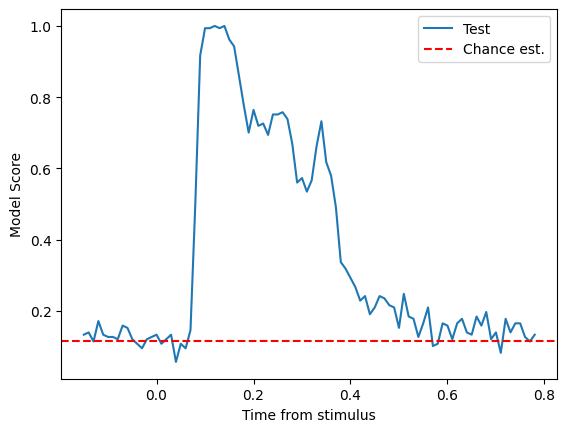

In [20]:
fig, ax = plt.subplots()
ax.plot(bins[:-1]+.05, scores_test, label = 'Test')
ax.axhline(np.mean(chance), linestyle = '--', label = 'Chance est.', c = 'r')
ax.legend()
ax.set_xlabel('Time from stimulus')
ax.set_ylabel('Model Score')